In [23]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

%matplotlib inline

# Annotation
filename = 'parsed_data_1.csv'
fn_ann = os.path.join('DO NOT TOUCH', 'GroundTruthData', 'GroundTruthLeft', filename)
ann = libfmp.c4.read_structure_annotation(fn_ann)
color_ann = plt.cm.viridis(np.linspace(0, 1, len(ann)))  # Use 'viridis' colormap

# SM
fn_wav = os.path.join('..', 'DO NOT TOUCH', 'Audio Files', 'Emmanuel', '01. Vitalic - Polkamatic.flac')
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(0.66, 1.5, 5)
x, x_duration, X, Fs_X, S, I = libfmp.c4.compute_sm_from_filename(fn_wav,
                                                L=81, H=10, L_smooth=1, thresh=1)

# Visualization
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1],
            title='Feature rate: %0.0f Hz'%(Fs_X))


ValueError: not enough values to unpack (expected 3, got 1)

# Utility Functions

In [1]:
def generate_beats_and_meters(beats, sr, hop_length,tempo, duration, time_signature=4):
    """Generate beat and meter grids within the duration of a song."""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    beats_per_meter = time_signature
    seconds_per_meter = seconds_per_beat * beats_per_meter
    beat_grid_forward = [first_beat_time + i * seconds_per_beat for i in range(int((duration - first_beat_time) / seconds_per_beat))]
    beat_grid_backward = [first_beat_time - i * seconds_per_beat for i in range(1, int(first_beat_time / seconds_per_beat) + 1)]
    beat_grid_backward.reverse()
    beat_grid = beat_grid_backward + beat_grid_forward
    meter_grid_forward = [first_beat_time + i * seconds_per_meter for i in range(int((duration - first_beat_time) / seconds_per_meter))]
    meter_grid_backward = [first_beat_time - i * seconds_per_meter for i in range(1, int(first_beat_time / seconds_per_meter) + 1)]
    meter_grid_backward.reverse()
    meter_grid = meter_grid_backward + meter_grid_forward

    return beat_grid, meter_grid

def calculate_ki_chroma(chromagram, sr, hop_length):
    """Calculate a key-invariant chromagram for a given audio waveform using KS key-finding algorithm."""
    chroma_vals = np.sum(chromagram, axis=1)
    maj_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    min_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    maj_corrs = np.correlate(chroma_vals, maj_profile, mode='same')
    min_corrs = np.correlate(chroma_vals, min_profile, mode='same')
    key_shift = np.argmax(np.concatenate((maj_corrs, min_corrs))) % 12
    return np.roll(chromagram, -key_shift, axis=0)


def apply_diagonal_median_filter(ssm, filter_length=5):
    """Apply a median filter diagonally across a self-similarity matrix (SSM)."""
    # Assuming ssm is square
    ssm_filtered = np.zeros_like(ssm)
    for d in range(-ssm.shape[0] + 1, ssm.shape[1]):
        diag = np.diagonal(ssm, offset=d)
        filtered_diag = scipy.ndimage.median_filter(diag, size=filter_length)
        if d >= 0:
            np.fill_diagonal(ssm_filtered[:,d:], filtered_diag)
        else:
            np.fill_diagonal(ssm_filtered[-d:,:], filtered_diag)
    return np.abs(ssm_filtered)


def find_repetitions(ssm, beat_grid_frames, min_length=16, max_length=128, p=0.1, ts=0.60):
    repetitions = {}
    for i in range(len(beat_grid_frames)):
        for length in range(min_length, max_length + 1, 4):
            for j in range(i + 1, len(beat_grid_frames)):  # Ensure j > i to avoid self-comparison
                if j - i < length:
                    continue
                # Extract the diagonal segment D_{i,j,l}
                Di_j_l = ssm[i:i+length, j:j+length].diagonal()
                quantile_value = scoreatpercentile(Di_j_l, p*100)
                if quantile_value > ts:
                    key = (i, length)
                    repetitions.setdefault(key, []).append((j, quantile_value))

    # Construct L, ensuring R_il sets with more than one j are included, and filter for best j score in case of overlap
    L = []
    for (i, l), js in repetitions.items():
        # Sort js by score to ensure the highest score is considered first
        sorted_js = sorted(js, key=lambda x: x[1], reverse=True)
        if len(sorted_js) > 1:
            # Include only the highest scoring j for each i, l pair
            best_j, best_score = sorted_js[0]
            L.append({'i': i, 'j': best_j, 'l': l, 'score': best_score})

    return L

def greedy_select_segments(L, total_frames, length_multiplier):
    """
    Apply a greedy selection algorithm on the list of repetition sets, prioritizing
    the sets based on l * score, and considering non-overlapping segments with higher scores
    that lie within the song's boundaries.

    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song, ensuring selections are within song bounds.

    Returns:
    - A list of selected repetition sets based on the greedy algorithm, with considerations for non-overlapping segments.
    """
    # Sort L by l * score in descending order
    sorted_L = sorted(L, key=lambda x: ((x['l'] * length_multiplier) * x['score']), reverse=True)

    selected_segments = []
    covered_frames = set()

    for segment in sorted_L:
        segment_start_i = segment['i']
        segment_end_i = segment['i'] + segment['l']

        segment_start_j = segment['j']
        segment_end_j = segment['j'] + segment['l']

        # Ensure the segment lies within the song's boundaries
        if not (segment_end_i <= total_frames and segment_end_j <= total_frames):
            continue

        # Create spans for the current segment for both 'i' and 'j'
        segment_span_i = set(range(segment_start_i, segment_end_i))
        segment_span_j = set(range(segment_start_j, segment_end_j))

        # Check for overlap with already covered frames for both 'i' and 'j' spans
        if segment_span_i & covered_frames or segment_span_j & covered_frames:
            # If there's overlap with either span, continue to the next segment without adding it to the selection
            continue

        # If no overlap, select this segment
        selected_segments.append(segment)
        # Mark these frames as covered for both 'i' and 'j' spans
        covered_frames |= segment_span_i
        covered_frames |= segment_span_j

    return selected_segments

def greedy_max_coverage(L, total_frames, weight_multiplier=1):
    """
    Apply a greedy selection algorithm on the list of repetition sets, aiming to
    maximize the number of frames covered by non-overlapping repeating segments,
    while ensuring that the segment boundaries fit within the song length in frames.

    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song.

    Returns:
    - A list of selected repetition sets based on the greedy algorithm, aiming to maximize frame coverage.
    """
    # Sort the list by a composite key that gives more weight to length than to score
    sorted_L = sorted(L, key=lambda x: (x['l'] * weight_multiplier) * x['score'], reverse=True)

    selected_segments = []
    covered_frames = set()

    for segment in sorted_L:
        # Calculate the frame span of the current segment and ensure it's within song boundaries
        if segment['i'] + segment['l'] <= total_frames and segment['j'] + segment['l'] <= total_frames:
            i_span = set(range(segment['i'], segment['i'] + segment['l']))
            j_span = set(range(segment['j'], segment['j'] + segment['l']))

            # Ensure no overlap with already covered frames
            if not (i_span & covered_frames or j_span & covered_frames):
                selected_segments.append(segment)
                covered_frames |= i_span
                covered_frames |= j_span

    return selected_segments

def plot_repetitions(ssm_1, repeating_segments_1, ssm_2, repeating_segments_2, padding_correction=0, algo=""):
    """Plotting and comparing SSMs and greedy selection algorithms with labels on repeating segments."""
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

    # Minimum and maximum similarity scores for the shared color bar
    vmin = min(np.min(ssm_1), np.min(ssm_2))
    vmax = max(np.max(ssm_1), np.max(ssm_2))

    # Plot settings
    cmap = 'viridis'
    aspect = 'equal'
    origin = 'lower'

    # Function to plot each SSM and its repeating segments
    def plot_ssm(ax, ssm, repeating_segments):
        ax.imshow(ssm, aspect=aspect, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)
        for idx, segment in enumerate(repeating_segments):
            i, j, l, score = segment['i'], segment['j'], segment['l'], segment['score']
            i_corrected = max(i - padding_correction, 0)
            j_corrected = max(j - padding_correction, 0)

            # Draw rectangles
            rect_ij = patches.Rectangle((j_corrected, i_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ij)

            rect_ji = patches.Rectangle((i_corrected, j_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ji)

            # Add labels in the middle of the rectangles
            label_text = f"{score*100:.2f}% match ({l} beats)"
            ax.text(j_corrected + l/2, i_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            ax.text(i_corrected + l/2, j_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # Plot the first SSM and its segments
    plot_ssm(axs[0], ssm_1, repeating_segments_1)
    axs[0].set_title('Median Filtered SSM')

    # Plot the second SSM and its segments
    plot_ssm(axs[1], ssm_2, repeating_segments_2)
    axs[1].set_title('Enhanced SSM')

    # Set the axis labels for the figure
    fig.text(0.5, 0.1, 'Time (beat frames)', ha='center')
    fig.text(0.1, 0.5, 'Time (beat frames)', va='center', rotation='vertical')

    # Set the main plot title based on the algo parameter
    if algo:
        fig.suptitle(f"{algo} Selection Results", fontsize=16, y=0.90)

    # Shared color bar for both subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Similarity Score')

    plt.show()

def combine_segments(segments, total_length):
    # Initialize list for processed segments with pair numbers
    processed_segments = []
    for idx, seg in enumerate(segments):
        # Assign unique pair numbers starting from 1
        pair_number = idx + 1
        # Append both the segment and its mirror with their respective pair numbers
        processed_segments.extend([
            (seg['i'], seg['i'] + seg['l'], pair_number),
            (seg['j'], seg['j'] + seg['l'], pair_number)
        ])

    # Sort the processed segments by their starting point
    processed_segments.sort(key=lambda x: x[0])

    all_segments = []
    # Initialize last_end to track the end of the last segment added
    last_end = 0

    for start, end, pair_num in processed_segments:
        # Check for a gap between this segment and the last, marking it as non-pattern if found
        if start > last_end:
            all_segments.append((last_end, start, 0))  # Non-pattern segment
        # Update last_end if this segment extends beyond the current last_end
        if end > last_end:
            all_segments.append((start, end, pair_num))
            last_end = end

    # Append a final non-pattern segment if there's remaining space in the total_length
    if last_end < total_length:
        all_segments.append((last_end, total_length, 0))

    return all_segments

def plot_chromagram_with_segments(chroma_sync, segments, beat_grid_times, sr=12000, hop_length=128, title=""):
    fig, ax = plt.subplots(figsize=(15, 4))
    librosa.display.specshow(chroma_sync, sr=sr, y_axis='chroma', x_axis='time',
                             x_coords=beat_grid_times, ax=ax, hop_length=hop_length)
    ax.set_ylabel('Chroma')
    ax.set_title(f'Chromagram with {title} SSM Segmentation' if title else 'Beat-Synced, Key-invariant Chromagram with SSM Segmentation')

    # Plot the segment lines on the chromagram
    def plot_segment_lines(ax, segments):
        total_frames = chroma_sync.shape[1]
        for segment in segments:
            if segment[0] > 0:  # Ignore the very start of the song
                start_time = beat_grid_times[segment[0]]
                ax.axvline(x=start_time, color='w', linestyle='--', linewidth=3)
            if segment[1] < total_frames:  # Ignore the very end of the song
                end_time = beat_grid_times[min(segment[1], len(beat_grid_times) - 1)]
                ax.axvline(x=end_time, color='w', linestyle='--', linewidth=3)

    plot_segment_lines(ax, segments)

    plt.tight_layout()
    plt.show()

# Load Audio, Extract Features, and Create Beat-Synchronous Chromagram

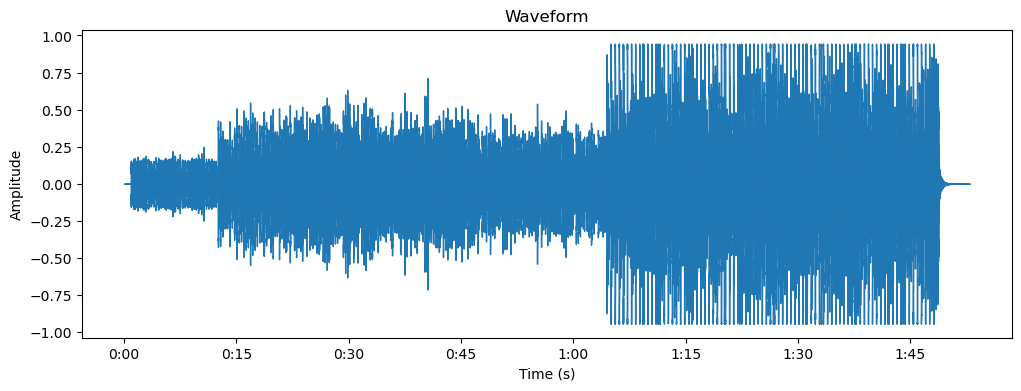

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
audio_path = 'DO NOT TOUCH/Audio Files/Emmanuel/01. Vitalic - Polkamatic.flac'  # Replace this with your actual filename
y, sr = librosa.load(audio_path, sr=None)

# Plot waveform (optional)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


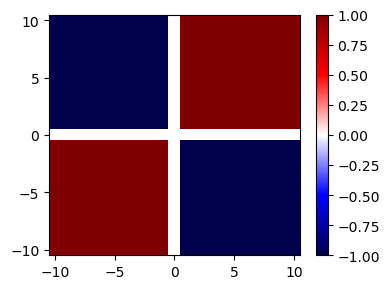

In [12]:
def compute_kernel_checkerboard_box(L):
    """Compute box-like checkerboard kernel [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size 2*L+1

    Returns:
        kernel (np.ndarray): Kernel matrix of size (2*L+1) x (2*L+1)
    """
    axis = np.arange(-L, L+1)
    kernel = np.outer(np.sign(axis), np.sign(axis))
    return kernel

L = 10
kernel = compute_kernel_checkerboard_box(L)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower',
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

## Visualizing the beat-synced chromagrams

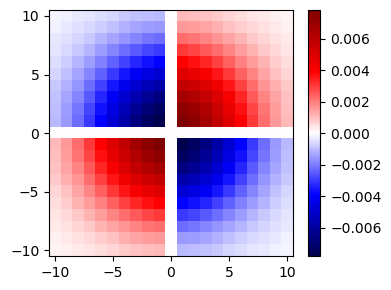

In [13]:
@jit(nopython=True)
def compute_kernel_checkerboard_gaussian(L, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1/2) / (L * var)
    axis = np.arange(-L, L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

L = 10
var = 0.5
kernel = compute_kernel_checkerboard_gaussian(L, var)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower',
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

## Calculate SSM and Path Enhancement
- Transpose `chroma_sync` before computing pairwise distances to ensure that the resulting SSM is suitable for identifying repeating segments across time. The size of this SSM will be determined by the number of time frames (or beat-synced frames) in the chroma feature matrix.
- Calculate the SSM using Pearson correlation coefficients
- Take the absolute values of the SSM, scaling the values from [0, 1], making the SSM values more intuitively interpretable in terms of similarity (where 1 represents maximum similarity and 0 represents maximum dissimilarity, in the context of the normalized scale)
- Apply median filter to the normalized SSM
- Path enhancement is used to enhance continuity along diagonal paths in the SSM, which represent repeating musical segments. It's particularly useful for highlighting temporal structures and patterns that recur over time by making repeating paths more pronounced and easier to identify, especially in pieces with complex structures or subtle repetitions.
    - `librosa.segement.path_enhance()` is inspired by the multi-angle path enhancement of [1], but differs by modeling tempo differences in the space of similarity matrices rather than re-sampling the underlying features prior to generating the self-similarity matrix.

[1]
Müller, Meinard and Frank Kurth. “Enhancing similarity matrices for music audio analysis.” 2006 IEEE International Conference on Acoustics Speech and Signal Processing Proceedings. Vol. 5. IEEE, 2006.

In [14]:
# @jit(nopython=True)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)
fig, ax, line = libfmp.b.plot_signal(nov, Fs = Fs_X, color='k')

NameError: name 'S' is not defined

In [15]:
L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=True)
fig, ax, line = libfmp.b.plot_signal(nov, Fs = Fs_X, color='k')
libfmp.b.plot_segments_overlay(ann, ax=ax, colors=color_ann, alpha=0.1, edgecolor='k', print_labels=False)
plt.tight_layout()

NameError: name 'S' is not defined

In [18]:
from libfmp.b import FloatingBox
float_box = libfmp.b.FloatingBox()

fn_wav = os.path.join('DO NOT TOUCH', 'Audio Files', 'Emmanuel', '01. Vitalic - Polkamatic.flac')


S_dict = {}
Fs_dict = {}
x, x_duration, X, Fs_X, S, I = libfmp.c4.compute_sm_from_filename(fn_wav,
                                                L=11, H=5, L_smooth=1, thresh=1)
S_dict[0], Fs_dict[0] = S, Fs_X
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1],
            title='Feature rate: %0.0f Hz'%(Fs_X), figsize=(4.5, 5.5))
float_box.add_fig(fig)

x, x_duration, X, Fs_X, S, I = libfmp.c4.compute_sm_from_filename(fn_wav,
                                                L=41, H=10, L_smooth=1, thresh=1)
S_dict[1], Fs_dict[1] = S, Fs_X
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1],
            title='Feature rate: %0.0f Hz'%(Fs_X), figsize=(4.5, 5.5))
float_box.add_fig(fig)
float_box.show()


figsize=(10,6)
L_kernel_set = [5, 10, 20, 40]
num_kernel = len(L_kernel_set)
num_SSM = len(S_dict)

fig, ax = plt.subplots(num_kernel, num_SSM, figsize=figsize)
for s in range(num_SSM):
    for t in range(num_kernel):
        L_kernel = L_kernel_set[t]
        S = S_dict[s]
        nov = compute_novelty_ssm(S, L=L_kernel, exclude=True)
        fig_nov, ax_nov, line_nov = libfmp.b.plot_signal(nov, Fs = Fs_dict[s],
                color='k', ax=ax[t,s], figsize=figsize,
                title='Feature rate = %0.0f Hz, $L_\mathrm{kernel}$ = %d'%(Fs_dict[s],L_kernel))
        libfmp.b.plot_segments_overlay(ann, ax=ax_nov, colors=color_ann, alpha=0.1,
                                       edgecolor='k', print_labels=False)
plt.tight_layout()
plt.show()

<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
C:\Users\xxmal\AppData\Local\Temp\ipykernel_4828\2381338305.py:42: SyntaxWarning: invalid escape sequence '\m'
  title='Feature rate = %0.0f Hz, $L_\mathrm{kernel}$ = %d'%(Fs_dict[s],L_kernel))
C:\Users\xxmal\AppData\Local\Temp\ipykernel_4828\2381338305.py:42: SyntaxWarning: invalid escape sequence '\m'
  title='Feature rate = %0.0f Hz, $L_\mathrm{kernel}$ = %d'%(Fs_dict[s],L_kernel))


TypeError: load() takes 1 positional argument but 2 were given